In [9]:
import tools
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


True

In [10]:
import os
import os
from langchain.chat_models import init_chat_model



llm = init_chat_model(
    "azure_openai:gpt-4.1-mini",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    api_version="2024-12-01-preview"
)


agent_tools = [tools.get_all_plants, tools.get_bloom_data]
llm_with_tools = llm.bind_tools(agent_tools)

In [22]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=('Du bist ein Assistent, der Informationen über die Blütezeit von Pflanzen bereitstellt.'
                                 'Anweisungen:'
                                 '- Du bekommst eine Anfrage ob eine Pflanze blüht und wann.'
                                 '- Nutze get_all_plants um eine Liste aller Pflanzen zu erhalten zu denen Daten existieren.'
                                 '- Prüfe ob die Pflanze aus der Anfrage in der Liste der Pflanzen enthalten ist.'
                                 '- Wenn die Pflanze nicht in der Liste ist, antworte mit: {"response": false, "reasoning": "Die Pflanze ist nicht in der Liste der bekannten Pflanzen."}'
                                 '- Dann nutze get_bloom_data mit der angefragten Pflanze, um Informationen über die Blütezeit zu erhalten. '
                                 'Antworte auf die Fragen in folgendme Format: \
                        Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
                                 'response soll auf true gesetzt werden, wenn die Pflanze blüht und false, wenn sie nicht blüht.'
                        ))

# Node
def agent(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

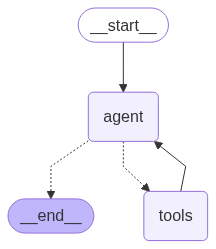

In [30]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(agent_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "agent")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [13]:
messages = [HumanMessage(content="Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die Erle schon angefangen zu blühen?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

Tool invoked with plant=erle, year=2020, type=beginn
Tool invoked with plant=erle, year=2020, type=ende
================================ Human Message =================================

Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die Erle schon angefangen zu blühen?
================================== Ai Message ==================================
Tool Calls:
  get_all_plants (call_C45ylRHsAfrfXJmNAn3lKsWc)
 Call ID: call_C45ylRHsAfrfXJmNAn3lKsWc
  Args:
================================= Tool Message =================================
Name: get_all_plants

apfel birke erle hasel winterraps winterroggen
================================== Ai Message ==================================
Tool Calls:
  get_bloom_data (call_hn7KD2UAuaSJ8iTJKSiocZvn)
 Call ID: call_hn7KD2UAuaSJ8iTJKSiocZvn
  Args:
    plant: erle
    year: 2020
    type: beginn
  get_bloom_data (call_crsA6JwRrE9WgDvDFdJ9LA6E)
 Call ID: call_crsA6JwRrE9WgDvDFdJ9LA6E
  Args:
    plant: erle
    year: 2020
    type:

In [16]:
import json
from utils import get_tokens
#base_prompt = 'Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
with open("datasets/dataset_24.json", "r") as file:
    dataset = json.load(file)


responses = []
for data in dataset:
    sentence = data["sentence"]
    prompt = [HumanMessage(content=sentence)]
    print(f"Processing: {sentence}")
    messages = react_graph.invoke({"messages": prompt})
    for m in messages['messages']:
        m.pretty_print()
    response = messages["messages"][-1].content
    cleaned_response = response.strip("```json").strip("```").strip()
    response_json = json.loads(cleaned_response)
    tokens = get_tokens(messages)
    responses.append({
        "id": data["id"],
        "plant": data["plant"],
        "city": data["city"],
        "date": data["date"],
        "sentence": sentence,
        "response": response_json["response"],
        "reasoning": response_json["reasoning"],
        "tokens": tokens
    })

print(responses)

with open("results/single_agent_24.json", "w") as file:
    json.dump(responses, file, indent=4)

Processing: Heute, am 11.04.2021, befinden wir uns in Berlin. Ist die Apfel gerade am Blühen?
Tool invoked with plant=apfel, year=2021, type=beginn
Tool invoked with plant=apfel, year=2021, type=ende
================================ Human Message =================================

Heute, am 11.04.2021, befinden wir uns in Berlin. Ist die Apfel gerade am Blühen?
================================== Ai Message ==================================
Tool Calls:
  get_all_plants (call_aw7cFFdAdqVHqzSUe6jpyiSq)
 Call ID: call_aw7cFFdAdqVHqzSUe6jpyiSq
  Args:
================================= Tool Message =================================
Name: get_all_plants

apfel birke erle hasel winterraps winterroggen
================================== Ai Message ==================================
Tool Calls:
  get_bloom_data (call_A0h2MoYSCKGqiVncOo10r78Y)
 Call ID: call_A0h2MoYSCKGqiVncOo10r78Y
  Args:
    plant: apfel
    year: 2021
    type: beginn
  get_bloom_data (call_G3ZdpUFi7Buj53VFdoejMdsj)
 Call ID

In [15]:
%load_ext autoreload
%autoreload 2

flower = tools.Flower("erle")
#flower = flower[flower.begin_data["Jahr"] == 2020]
flower.begin_data["Jahr"]

tools.get_bloom_data("erle", 2020, "beginn")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tool invoked with plant=erle, year=2020, type=beginn


{'data': {'Jahr': {5: 2020},
  'Gebietsmittel': {5: '12.02. '},
  'Abweichung vom Mittel': {5: '-16 Tage'}},
 'info': 'Tabelle mit den mittleren Beobachtungsterminen und den Abweichungen vom Mittel der Phase "Erle: Blüh-Beginn" im Gebiet Deutschland für verschiedene Jahre. Positive Abweichungen bedeuten, dass die Phase im entsprechendem Jahr später aufgetreten ist.'}